In [80]:
# No preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

train_data = pd.read_csv('Bugfree_fulltrain.csv', header=None, names=['label', 'text'])
test_data = pd.read_csv('balancedtest.csv', header=None, names=['label', 'text'])

X_train = train_data['text']
y_train = train_data['label']
# minus all labels by one, so that range is now [0,3] for classification
y_train -= 1
X_test = test_data['text']
y_test = test_data['label']
y_test -= 1

In [1]:
# Summarization version 1
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

X_train = pd.read_csv('summarized_fulltrain.csv', header=None)
X_test = pd.read_csv('summarized_test.csv', header=None)

train_data = pd.read_csv('Bugfree_fulltrain.csv', header=None, names=['label', 'text'])
test_data = pd.read_csv('balancedtest.csv', header=None, names=['label', 'text'])

y_train = train_data['label']
# minus all labels by one, so that range is now [0,3] for classification
y_train -= 1
y_test = test_data['label']
y_test -= 1

X_train = X_train.drop(X_train.index[0])
X_test = X_test.drop(X_test.index[0])

In [1]:
# Summarization version 2
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

train_data = pd.read_csv('merged_summarized_fulltrain.csv')
test_data = pd.read_csv('merged_summarized_test.csv')

X_train = train_data['text']
y_train = train_data['label']
X_test = test_data['text']
y_test = test_data['label']

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize text
max_len = 128
train_encodings = tokenizer(X_train.values.tolist(), truncation=True, padding=True, max_length=max_len)

# Convert to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

# Batch and shuffle datasets
batch_size = 64
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_split_size = int(len(X_train) / batch_size * 0.85)
true_train = train_dataset.take(train_split_size)
vali_dataset = train_dataset.skip(train_split_size)

In [4]:
from transformers import TFBertForSequenceClassification
# Load pre-trained BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4) # Adjust num_labels according to your number of classes

# Compile the model
loss = SparseCategoricalCrossentropy(from_logits=True)
metric = SparseCategoricalAccuracy('accuracy')
optimizer = Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
epochs = 1
model.fit(true_train, validation_data=vali_dataset, batch_size=batch_size, epochs=epochs)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



648/648 [==============================] - 9190s 14s/step - loss: 0.2256 - accuracy: 0.9261 - val_loss: 0.0574 - val_accuracy: 0.9810


In [5]:
test_encodings = tokenizer(X_test.values.tolist(), truncation=True, padding=True, max_length=max_len)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))
test_dataset = test_dataset.batch(batch_size)
# Evaluate the model
results = model.evaluate(test_dataset)
print('Test Loss:', results[0])
print('Test Accuracy:', results[1])

47/47 [==============================] - 192s 4s/step - loss: 1.9870 - accuracy: 0.5110
Test Loss: 1.9869776964187622
Test Accuracy: 0.5109999775886536


47/47 [==============================] - 192s 4s/step
0.511
0.4934899692248792


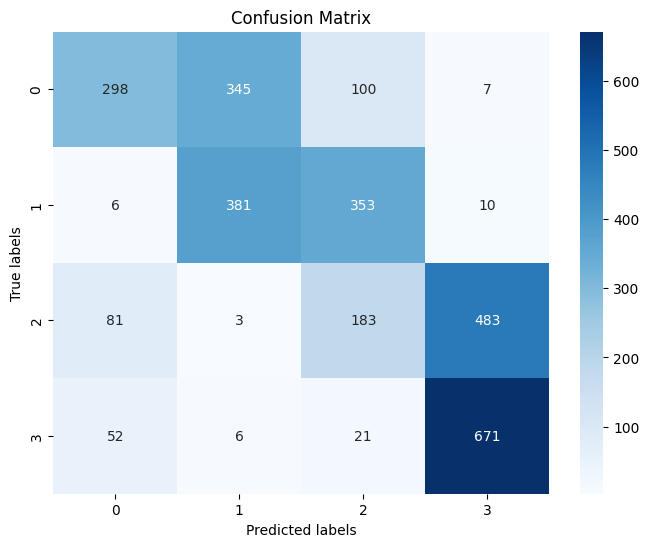

In [8]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras import activations
y_pred = np.argmax(activations.softmax(tf.convert_to_tensor(model.predict(test_dataset).logits)).numpy(), axis = 1)
score = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
print(acc)
print(score)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [9]:
import pickle
model.save_pretrained('./model/clf3')
with open('./model/info.pkl', 'wb') as f:
    pickle.dump(('bert-base-uncased', 128), f)